## Performance Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchvision.transforms as transforms
from dataset import TestDataset, TrainDataset
from model_gru import CNNtoRNN
import matplotlib.pyplot as plt  
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import single_meteor_score
import evaluate
import nltk
import seaborn as sns
nltk.download('wordnet')


IMAGES_PATH = './flickr8/Images'
CAPTIONS_PATH = './flickr8/captions.txt'

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ArsalanAnwar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
test_dataset = TrainDataset(CAPTIONS_PATH, IMAGES_PATH, transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    ))

In [6]:
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(test_dataset.caption_vocab), num_layers=1).to(device)


In [7]:
checkpoint = torch.load('./gru_single_layer/epoch=11_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNNtoRNN(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [8]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"TOTAL PARAMS: {pytorch_total_params}")
print(f"TOTAL TRAINABLE PARAMS {pytorch_total_trainable_params}")

TOTAL PARAMS: 92290944
TOTAL TRAINABLE PARAMS 5548608


In [9]:
vocab = test_dataset.caption_vocab.to(device)
results = []
predictions = []
references = []

for idx, (img_label, img, caption) in enumerate(test_dataset):
    sample_img = img.to(device)
    sample_img_label = img_label
    sample_img_caption = caption
    generated_caption = model.caption_image(sample_img, vocab)
    target_caption = [vocab.lookup_token(token) for token in caption]
    reference = ' '.join(target_caption[1:-2])
    prediction = ' '.join(generated_caption[1:-2])
    result = {
        'img_label': img_label,
        'img': img.T,
        'target_caption': [vocab.lookup_token(token) for token in caption],
        'generated_caption': generated_caption
    }
    results.append(result)
    references.append([reference])
    predictions.append(prediction)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/1000268201_693b08cb0e.jpg
Original Caption: A little girl in a pink dress going into a wooden cabin .
Generated Caption: A girl in a pink shirt is standing in front of a large tree .


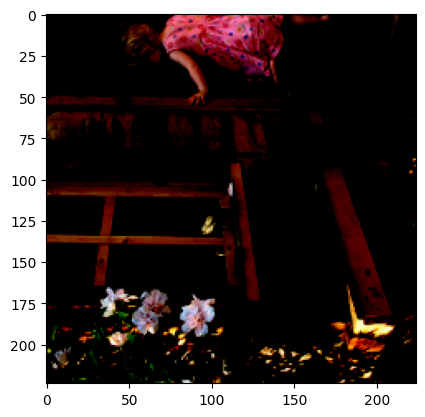

In [10]:
def show_image_with_caption(i):
    print(f"Image: {results[i]['img_label']}")
    print(f"Original Caption: {' '.join(results[i]['target_caption'][1:-2])}")
    print(f"Generated Caption: {' '.join(results[i]['generated_caption'][1:-2])}")
    plt.imshow(results[i]['img'])

show_image_with_caption(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/1001773457_577c3a7d70.jpg
Original Caption: Two dogs on pavement moving toward each other .
Generated Caption: A dog is running through the snow .


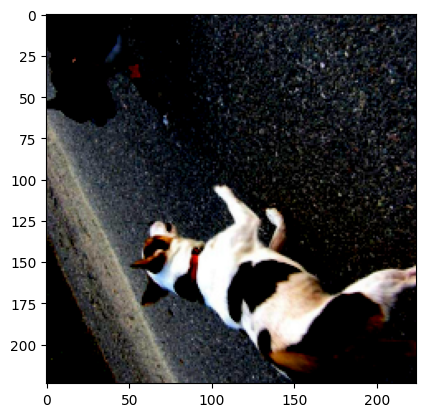

In [11]:
show_image_with_caption(1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/101654506_8eb26cfb60.jpg
Original Caption: The white and brown dog is running over the surface of the snow .
Generated Caption: A dog is running through the snow .


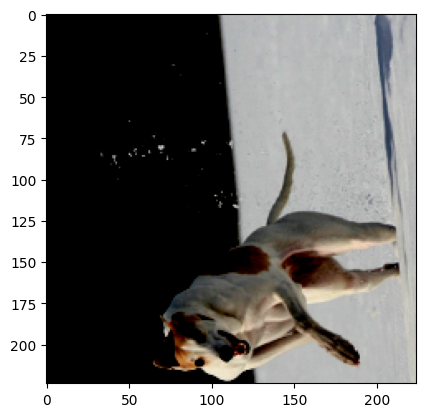

In [12]:
show_image_with_caption(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/1020651753_06077ec457.jpg
Original Caption: The white dog is playing in a green field with a yellow toy .
Generated Caption: A dog is running through the grass .


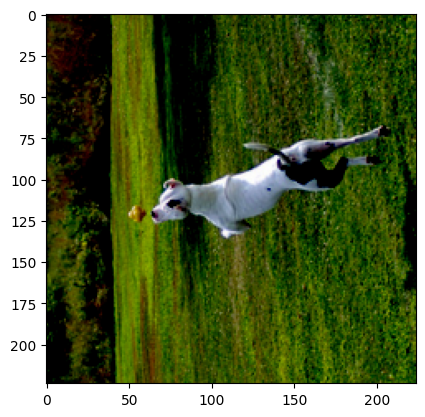

In [13]:
show_image_with_caption(15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/1048710776_bb5b0a5c7c.jpg
Original Caption: Several young people sitting on a rail above a crowded beach .
Generated Caption: A group of people are standing in a river .


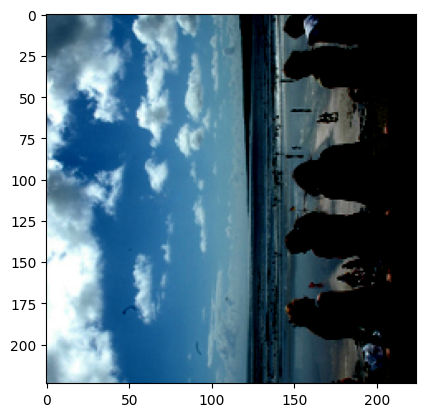

In [14]:
show_image_with_caption(35)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: ./flickr8/Images/1094462889_f9966dafa6.jpg
Original Caption: The brown dog is out in the snow .
Generated Caption: A dog is running through the snow .


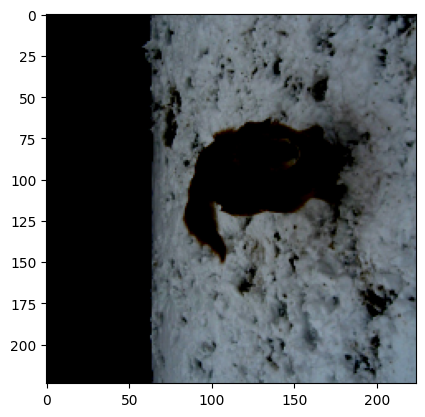

In [15]:
show_image_with_caption(80)

In [16]:
number_samples = 0
sum_bleu_scores = 0
sum_gleu_scores = 0
sum_meteor_scores = 0
for result in results:
    number_samples += 1
    
    sample_references = [result['target_caption']]
    candidates = result['generated_caption']
    sum_bleu_scores += sentence_bleu(sample_references, candidates)
    sum_gleu_scores = sentence_gleu(sample_references, candidates)
    sum_meteor_scores += single_meteor_score(result['target_caption'], result['generated_caption'])

In [25]:
avg_bleu_score = sum_bleu_scores / number_samples
print(f"BLEU SCORE: {avg_bleu_score}")

avg_gleu_score = sum_gleu_scores / number_samples
print(f"GLEU SCORE: {avg_gleu_score}")

avg_meteor_score = sum_meteor_scores / number_samples
print(f"METEOR SCORE: {avg_meteor_score}")

BLEU SCORE: 0.02591774667533982
GLEU SCORE: 3.433169914445406e-05
METEOR SCORE: 0.41046285401622284


In [18]:
' '.join(results[4]['target_caption'][1:-2])

'The man with pierced ears is wearing glasses and an orange hat .'

In [19]:
def print_evaluation_results(results_dict):
    for key in results_dict.keys():
        print(f"{key} : {results_dict[key]}")

#### BLEU and Rouge Evaluation
Reference: https://medium.com/@sthanikamsanthosh1994/understanding-bleu-and-rouge-score-for-nlp-evaluation-1ab334ecadcb

In [20]:
bleu = evaluate.load("bleu")

bleu_results = bleu.compute(predictions=predictions, references=references)

print_evaluation_results(bleu_results)

bleu : 0.03450728557705889
precisions : [0.26632340797590714, 0.05375142338998777, 0.01647205283967125, 0.006013068571864432]
brevity_penalty : 1.0
length_ratio : 1.1658738248952316
translation_length : 102935
reference_length : 88290


In [21]:
rouge = evaluate.load("rouge")

rouge_results = rouge.compute(predictions=predictions, references=references)

print_evaluation_results(rouge_results)

rouge1 : 0.2534894975003642
rouge2 : 0.06154158227932841
rougeL : 0.2281238778774334
rougeLsum : 0.22813528063280664


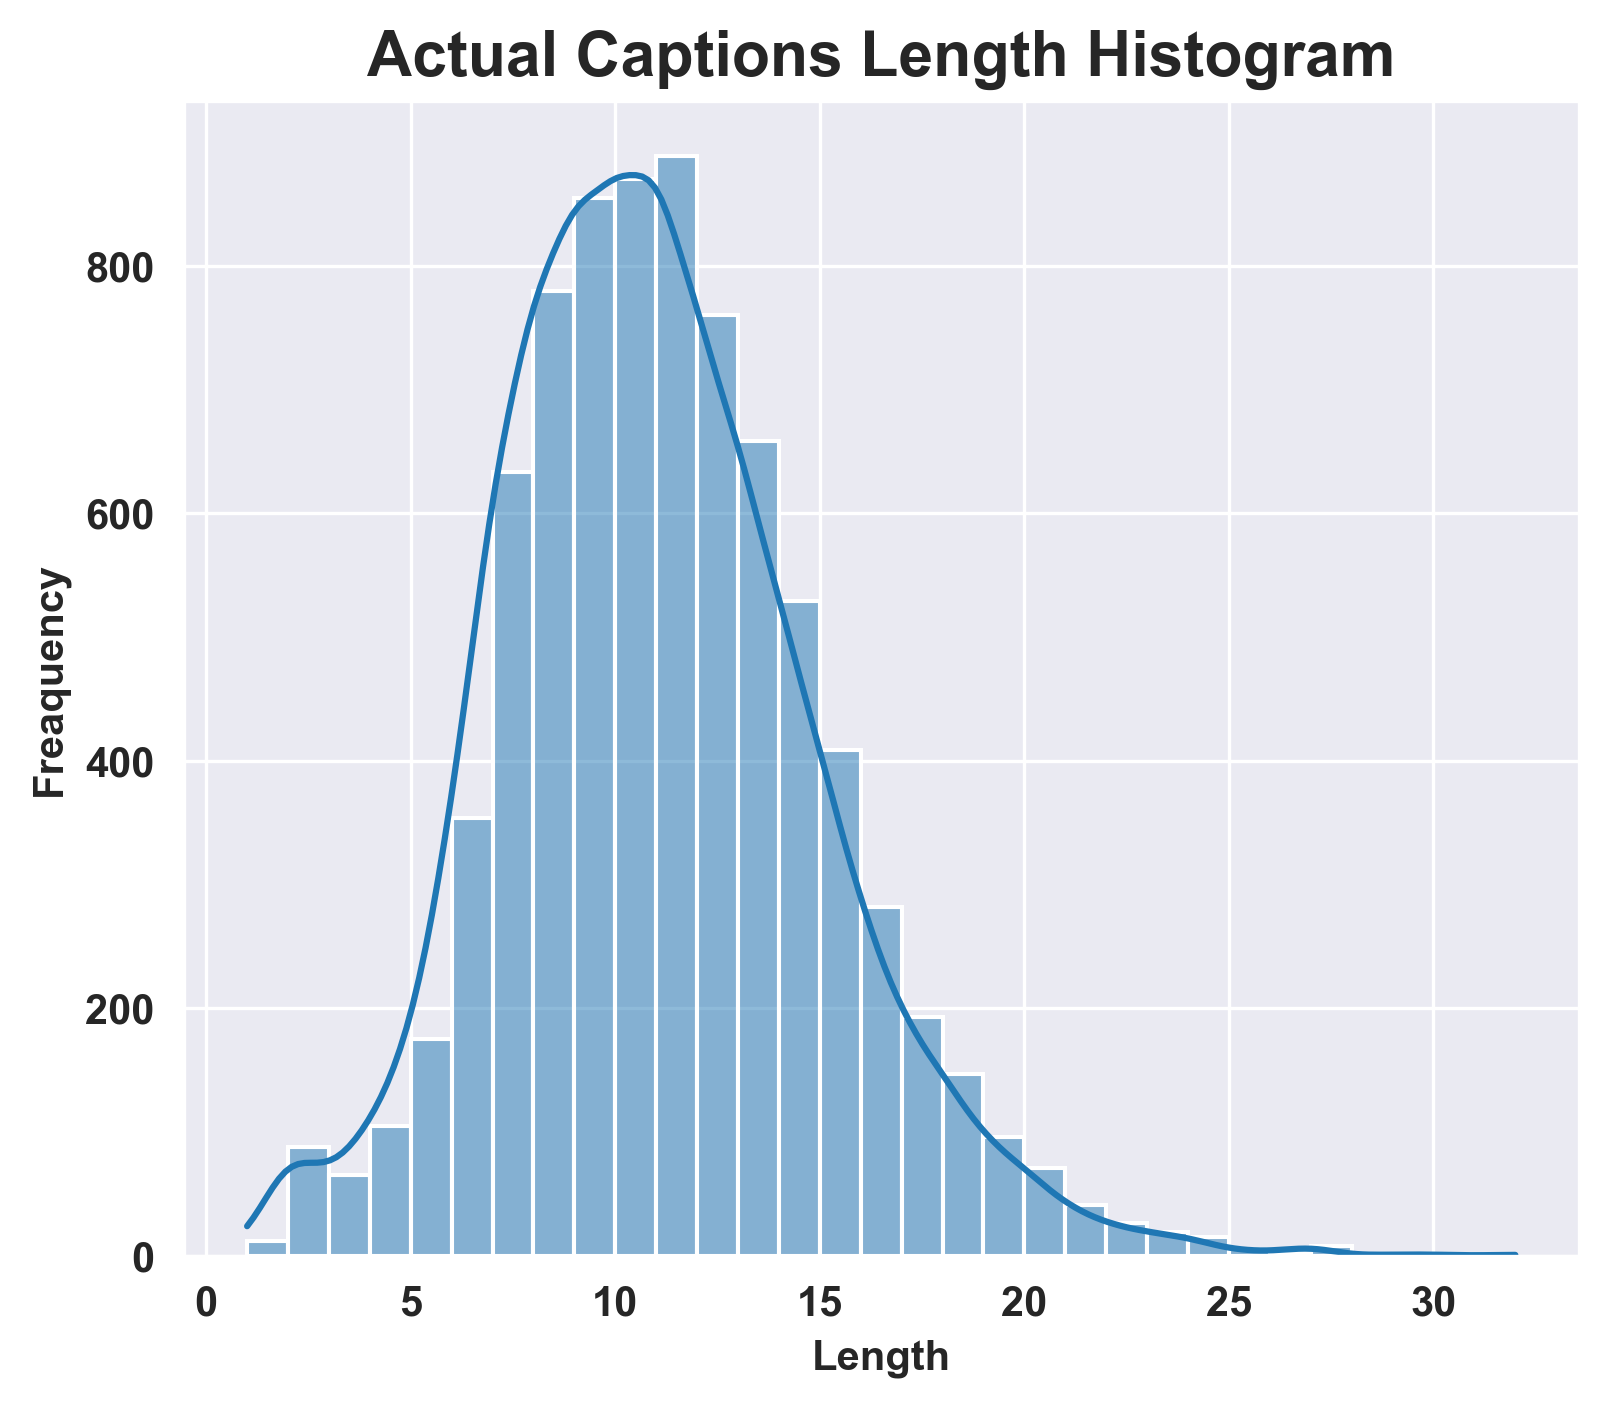

In [22]:
plt.figure(figsize=(6, 5), dpi=300)
sns.set_style('darkgrid')
sns.histplot(x=[len(x[0].split(' ')) for x in references], kde=True, binwidth=1) 
plt.title(f'Actual Captions Length Histogram', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Length', fontweight='bold')
plt.ylabel('Freaquency', fontweight='bold')
plt.show()


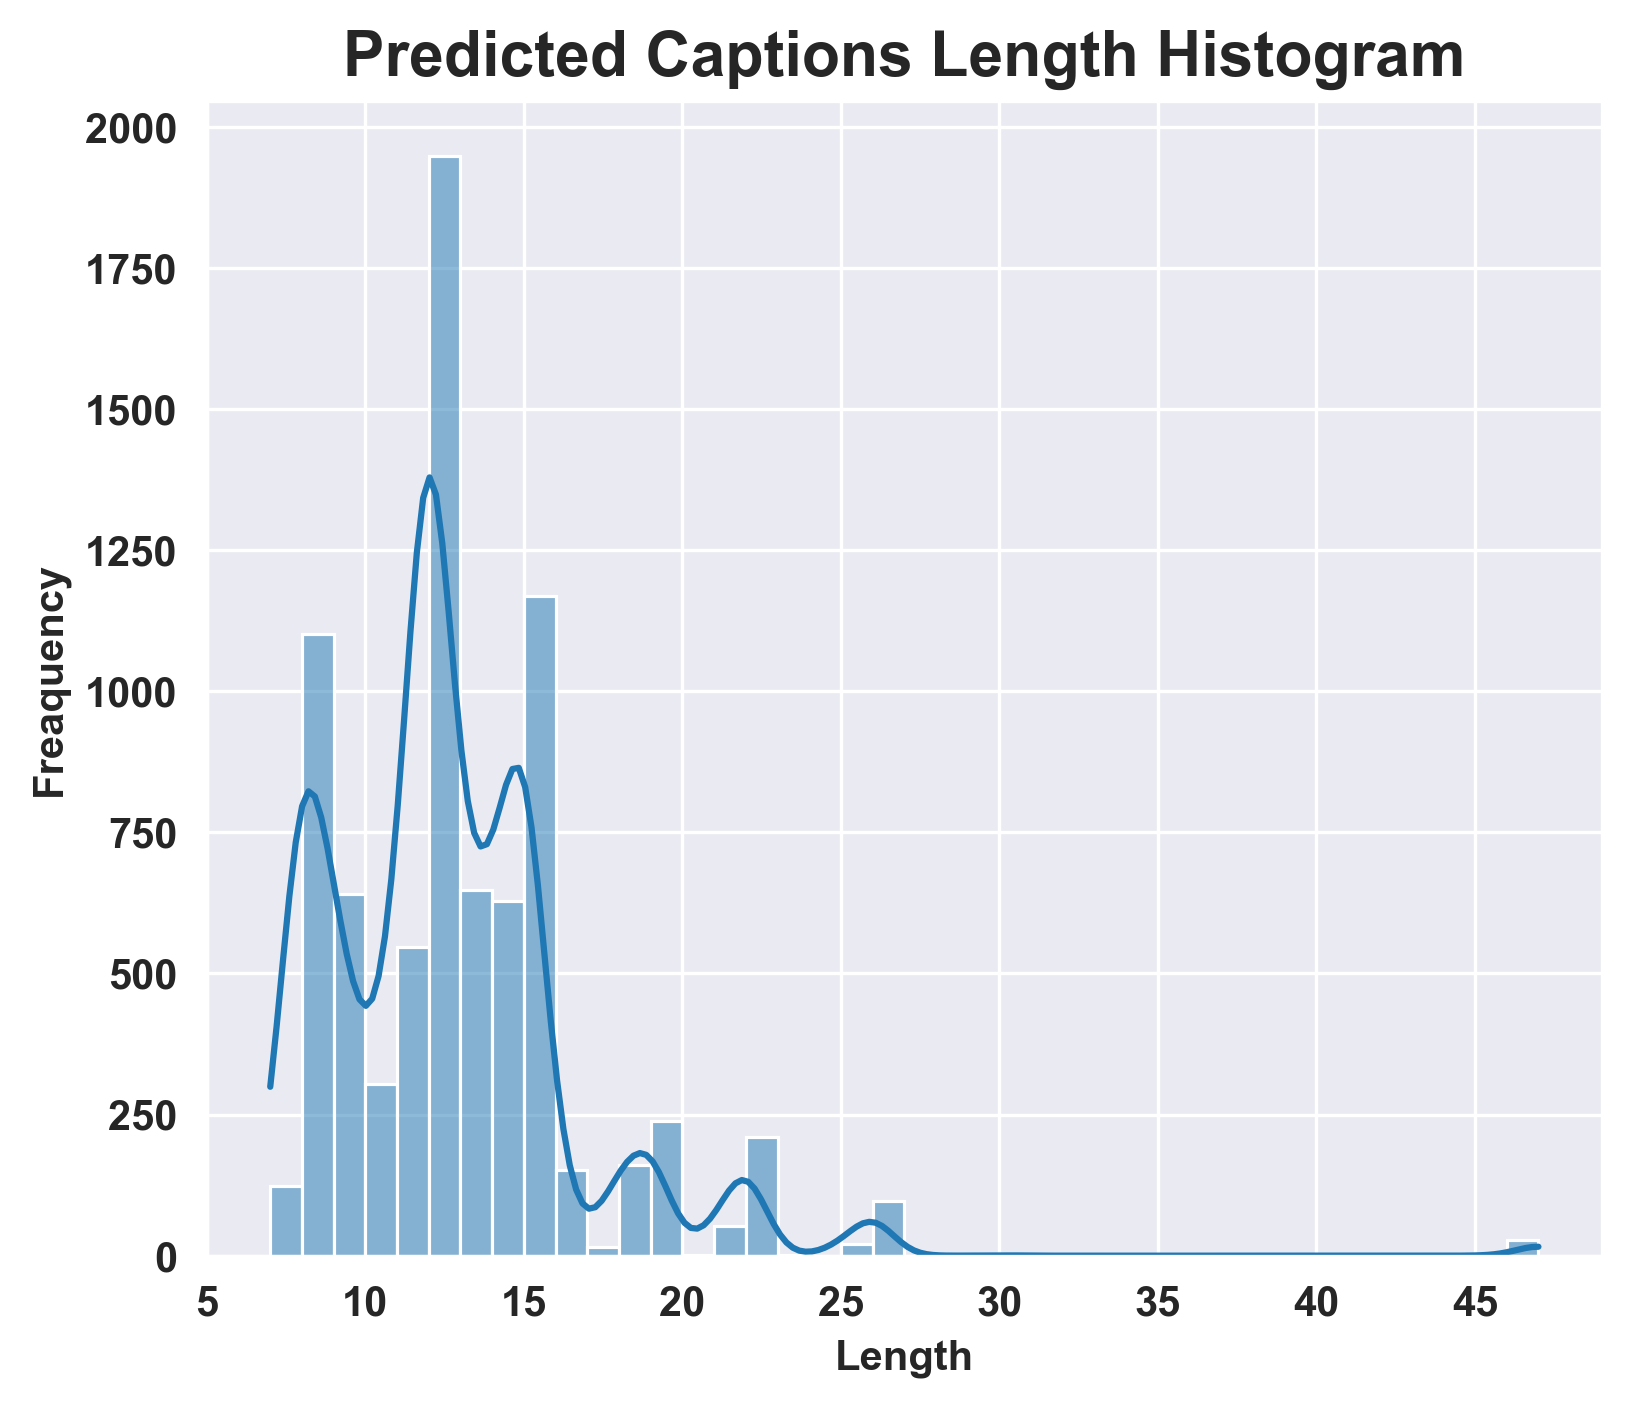

In [23]:
plt.figure(figsize=(6, 5), dpi=300)
sns.set_style('darkgrid')
sns.histplot(x=[len(x.split(' ')) for x in predictions], kde=True, binwidth=1) 
plt.title(f'Predicted Captions Length Histogram', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Length', fontweight='bold')
plt.ylabel('Freaquency', fontweight='bold')
plt.show()